# Seasonal Flu Vaccine Survey Data Analysis

## Overview

This project explores the National 2009 H1N1 Flu Survey (NHFS), which was a phone survey that asked respondents if they received the H1N1 and seasonal flu vaccines, as well as additional questions about their socioeconomic, demographic background, and opinions on illness risks and vaccine effectiveness. For the purpose of this project, the Public Health Institute would like to better understand the prediction of how likely individuals are to receive their seasonal flu vaccines. Especially during the current COVID-19 pandemic, they would like to focus their efforts on outreach to communities that would benefit from more vaccine information/resources. 

This notebook will analyze and compare regression and classification models based on whether or not the respondent received the seasonal flu vaccine and if certain features better help predict this outcome. 

## Business Understanding

The goal of this analysis is to understand what drives the models and which features are important in the prediction of individuals who will get the seasonal flu vaccine or not. The Public Health Institute should be able to use this understanding to minimize the amount of people that could've benefited from vaccine outreach and see what factors might contribute the most to individuals choosing not to receive the vaccine. By knowing this, the Public Health Institute can focus their efforts on specific communities and aid in providing the necessary resources to increase vaccine rates and in return, better understand vaccine effectiveness. 

The models outlined will predict the probability of individuals receiving the seasonal flu vaccine from data provided by DrivenData (a subset of the survey data from 2009 NHFS).

## Data Understanding

The NHFS data subset includes a features and labels set. The features set contains the different survey questions while the labels set contains the target variables, which are whether the respondents received the vaccines. Each row in the dataset represents one person and is identified by a respondent ID. For all binary variables, 0 = No and 1 = Yes. The dataset contains 26,707 entries. For this analysis, only the seasonal flu label will be used. In addition, specific H1N1 survey features will not be used.

In [79]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import category_encoders as ce

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.metrics import precision_score, accuracy_score, f1_score, recall_score, roc_auc_score, plot_confusion_matrix

In [2]:
features = pd.read_csv('data/training_set_features.csv')

In [3]:
features.head()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb


In [4]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26707 entries, 0 to 26706
Data columns (total 36 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   respondent_id                26707 non-null  int64  
 1   h1n1_concern                 26615 non-null  float64
 2   h1n1_knowledge               26591 non-null  float64
 3   behavioral_antiviral_meds    26636 non-null  float64
 4   behavioral_avoidance         26499 non-null  float64
 5   behavioral_face_mask         26688 non-null  float64
 6   behavioral_wash_hands        26665 non-null  float64
 7   behavioral_large_gatherings  26620 non-null  float64
 8   behavioral_outside_home      26625 non-null  float64
 9   behavioral_touch_face        26579 non-null  float64
 10  doctor_recc_h1n1             24547 non-null  float64
 11  doctor_recc_seasonal         24547 non-null  float64
 12  chronic_med_condition        25736 non-null  float64
 13  child_under_6_mo

In [5]:
labels = pd.read_csv('data/training_set_labels.csv')

In [6]:
labels.head()

,respondent_id,h1n1_vaccine,seasonal_vaccine
0,0,0,0
1,1,0,1
2,2,0,0
3,3,0,1
4,4,0,0


In [7]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26707 entries, 0 to 26706
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   respondent_id     26707 non-null  int64
 1   h1n1_vaccine      26707 non-null  int64
 2   seasonal_vaccine  26707 non-null  int64
dtypes: int64(3)
memory usage: 626.1 KB


## Data Preparation

Since the data is given in two sets, separated by the features and labels (targets), I will merge the two sets into one dataframe. Secondly, I will drop the features specific to H1N1 and the H1N1 vaccine label. Although there is probably some correlation between the H1N1 and seasonal flu vaccine, this analysis will focus on seasonal flu and will discuss implications of using the H1N1 data later on. Missing values will be explored and any additional cleaning needed during data exploration.

In [8]:
df = pd.merge(features, labels, on="respondent_id")

In [9]:
df.head()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN,0,0
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,0,1
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,0,0
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN,0,1
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,0,0


In [10]:
df.set_index('respondent_id')

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine
respondent_id,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN,0,0
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,0,1
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,...,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,0,0
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN,0,1
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26702,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,Own,Not in Labor Force,qufhixun,Non-MSA,0.0,0.0,NaN,NaN,0,0
26703,1.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,Rent,Employed,lzgpxyit,"MSA, Principle City",1.0,0.0,fcxhlnwr,cmhcxjea,0,0
26704,2.0,2.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,...,Own,NaN,lzgpxyit,"MSA, Not Principle City",0.0,0.0,NaN,NaN,0,1


In [16]:
h1n1_cols = [
    'h1n1_vaccine', 'opinion_h1n1_sick_from_vacc', 'opinion_h1n1_risk',
    'opinion_h1n1_vacc_effective', 'doctor_recc_h1n1', 'h1n1_knowledge',
    'h1n1_concern'
]
df = df.drop(columns=h1n1_cols)

In addition, a few of these features' values are represented as short random character strings. Since it will be difficult to interpret the relationship of these features to the target, these features will be excluded.

In [63]:
rand_cols = ['hhs_geo_region', 'employment_industry', 'employment_occupation']

df = df.drop(columns=rand_cols)

In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26707 entries, 0 to 26706
Data columns (total 28 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   respondent_id                26707 non-null  int64  
 1   behavioral_antiviral_meds    26636 non-null  float64
 2   behavioral_avoidance         26499 non-null  float64
 3   behavioral_face_mask         26688 non-null  float64
 4   behavioral_wash_hands        26665 non-null  float64
 5   behavioral_large_gatherings  26620 non-null  float64
 6   behavioral_outside_home      26625 non-null  float64
 7   behavioral_touch_face        26579 non-null  float64
 8   doctor_recc_seasonal         24547 non-null  float64
 9   chronic_med_condition        25736 non-null  float64
 10  child_under_6_months         25887 non-null  float64
 11  health_worker                25903 non-null  float64
 12  health_insurance             14433 non-null  float64
 13  opinion_seas_vac

There is a lot of missing data, which is not surprising for survey data. I'm going to utilize SimpleImputer later during the preprocessing step to fill missing values with the median of from the training data.

In [65]:
df.isna().sum()

respondent_id                      0
behavioral_antiviral_meds         71
behavioral_avoidance             208
behavioral_face_mask              19
behavioral_wash_hands             42
behavioral_large_gatherings       87
behavioral_outside_home           82
behavioral_touch_face            128
doctor_recc_seasonal            2160
chronic_med_condition            971
child_under_6_months             820
health_worker                    804
health_insurance               12274
opinion_seas_vacc_effective      462
opinion_seas_risk                514
opinion_seas_sick_from_vacc      537
age_group                          0
education                       1407
race                               0
sex                                0
income_poverty                  4423
marital_status                  1408
rent_or_own                     2042
employment_status               1463
census_msa                         0
household_adults                 249
household_children               249
s

In [66]:
df.describe()

,respondent_id,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,household_adults,household_children,seasonal_vaccine
count,26707.000000,26636.000000,26499.000000,26688.000000,26665.000000,26620.00000,26625.000000,26579.000000,24547.000000,25736.000000,25887.000000,25903.000000,14433.00000,26245.000000,26193.000000,26170.000000,26458.000000,26458.000000,26707.000000
mean,13353.000000,0.048844,0.725612,0.068982,0.825614,0.35864,0.337315,0.677264,0.329735,0.283261,0.082590,0.111918,0.87972,4.025986,2.719162,2.118112,0.886499,0.534583,0.465608
std,7709.791156,0.215545,0.446214,0.253429,0.379448,0.47961,0.472802,0.467531,0.470126,0.450591,0.275266,0.315271,0.32530,1.086565,1.385055,1.332950,0.753422,0.928173,0.498825
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,6676.500000,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,4.000000,2.000000,1.000000,0.000000,0.000000,0.000000
50%,13353.000000,0.000000,1.000000,0.000000,1.000000,0.00000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.00000,4.000000,2.000000,2.000000,1.000000,0.000000,0.000000
75%,20029.500000,0.000000,1.000000,0.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.00000,5.000000,4.000000,4.000000,1.000000,1.000000,1.000000
max,26706.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,5.000000,5.000000,5.000000,3.000000,3.000000,1.000000


In [67]:
df[[c for c in df.columns if df[c].dtype == 'object']].describe()

,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,census_msa
count,26707,25300,26707,26707,22284,25299,24665,25244,26707
unique,5,4,4,2,3,2,2,3,3
top,65+ Years,College Graduate,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,"MSA, Not Principle City"
freq,6843,10097,21222,15858,12777,13555,18736,13560,11645


## Modeling

The dataset will be split into train and test subsets for model validation. From there, a pipeline is built out to help iterate through different models, including logistic regression and random forest. These models were initially chosen due to its more simplistic nature in being able to better understand what drives the models and what features are most important. This will allow me to address the business problem more adequately rather than trying to built the best performing model.

The baseline is a model-less baseline, which is simply the probability of respondents in the dataset receiving the flu vaccine or not. 

In [69]:
#identifying X and y; splitting data into training and testing sets
X = df.drop(['seasonal_vaccine', 'respondent_id'], axis=1)
y = df['seasonal_vaccine']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

In [70]:
#code from lindsey; creates different lists of columns that needs different preprocessing
num_cols = []
cols_to_ohe = []
cols_to_freq = []

for c in X_train.columns:
    # Want to grab numeric columns
    if X_train[c].dtype in ['float64']:
        num_cols.append(c)

    # Then grab columns with fewer than 10 unique values
    elif len(X_train[c].unique()) < 10:
        cols_to_ohe.append(c)

    # Then grab columns with more than 10, since we won't OHE those
    else:
        cols_to_freq.append(c)

In [71]:
#preprocessing steps
num_transformer = Pipeline(steps=[
    ('num_imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())])

ohe_transformer = Pipeline(steps=[
    ('ohe_imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('ohencoder', OneHotEncoder(handle_unknown='ignore'))])

freq_transformer = Pipeline(steps=[
    ('freq_imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('freq_enc', ce.count.CountEncoder(normalize=True, 
                                       handle_unknown=0,
                                       min_group_size=0.001,
                                       min_group_name='Other'))])

In [72]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('ohe', ohe_transformer, cols_to_ohe),
        ('freq', freq_transformer, cols_to_freq)])

### Initial Baseline

The seasonal flu vaccine target has pretty balanced classes, roughly half of respondents received the vaccine.

In [68]:
#model-less baseline
df['seasonal_vaccine'].value_counts(normalize=True)

0    0.534392
1    0.465608
Name: seasonal_vaccine, dtype: float64

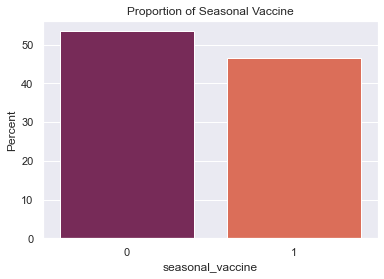

In [61]:
#plotting the model-less baseline to visualize
sns.set_theme(style='darkgrid')

ax = sns.barplot(x='seasonal_vaccine',
                 y='seasonal_vaccine',
                 data=df,
                 estimator=lambda x: len(x) / len(df) * 100,
                 palette='rocket')
ax.set(ylabel="Percent")
ax.set(title='Proportion of Seasonal Vaccine');

### First Iteration: Logistic Regression Model

In [73]:
clf_logreg = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression(solver='sag'))])

In [77]:
clf_logreg.fit(X_train, y_train)

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['behavioral_antiviral_meds',
                                                   'behavioral_avoidance',
                                                   'behavioral_face_mask',
                                                   'behavioral_wash_hands',
                                                   'behavioral_large_gatherings',
                                                   'behavioral_outside_home',
                                                   'behavioral_touch_face',
                     

In [83]:
y_hat_train = clf_logreg.predict(X_train)
y_hat_test = clf_logreg.predict(X_test)

print('Training Precision: ', precision_score(y_train, y_hat_train))
print('Testing Precision: ', precision_score(y_test, y_hat_test))
print('\n\n')

print('Training Recall: ', recall_score(y_train, y_hat_train))
print('Testing Recall: ', recall_score(y_test, y_hat_test))
print('\n\n')

print('Training Accuracy: ', accuracy_score(y_train, y_hat_train))
print('Testing Accuracy: ', accuracy_score(y_test, y_hat_test))
print('\n\n')

print('Training F1-Score: ', f1_score(y_train, y_hat_train))
print('Testing F1-Score: ', f1_score(y_test, y_hat_test))

Training Precision:  0.7729412995709951
Testing Precision:  0.7746717492587887



Training Recall:  0.7398838141025641
Testing Recall:  0.7462260301917585



Training Accuracy:  0.7768780716124503
Testing Accuracy:  0.7839760389367278



Training F1-Score:  0.7560513791515275
Testing F1-Score:  0.7601828761429759


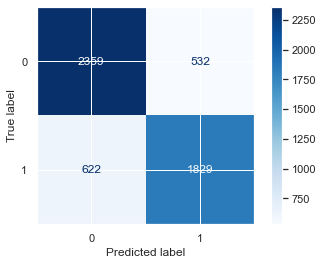

In [84]:
plot_confusion_matrix(clf_logreg, X_test, y_test, cmap=plt.cm.Blues)
plt.show()

In [ ]:
# cross_validate(clf_logreg, X_train, y_train, scoring='roc_auc', return_train_score=True, cv=3)

With the logistic regression model, our scores indicate that is better than the baseline in terms of predicting whether or not someone receives the vaccine.

There are more true negatives than true positives,

### Second Iteration: Decision Tree Model

In [75]:
clf_dt = Pipeline(steps=[('preprocessor', preprocessor),
                         ('classifier', DecisionTreeClassifier())])

In [76]:
cross_validate(clf_dt, X_train, y_train, scoring='roc_auc', return_train_score=True, cv=3)

{'fit_time': array([0.13750505, 0.12428617, 0.13175201]),
 'score_time': array([0.02054572, 0.02453685, 0.022084  ]),
 'test_score': array([0.67362969, 0.67141454, 0.67824031]),
 'train_score': array([0.99999215, 0.99999222, 0.99999219])}

### Third Iteration: Grid Search